In [1]:
#google colabon:
#from keras.utils import plot_model
#plot_model(model)

load = False

import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers import Dense, Input, LSTM, Concatenate, Lambda
from keras.models import Model
from keras.callbacks import History, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from sklearn.decomposition import PCA
from keras import backend as K
from keras.losses import categorical_crossentropy

RDKit WARNING: [22:26:35] Enabling RDKit 2019.09.1 jupyter extensions
Using TensorFlow backend.
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

# SMILES dataset

In [2]:
# beolvasás és train-test bontás
smifile = "10k.txt"#"gdb11_size08.smi"
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print("Train size: ",smiles_train.shape)
print("Test size",smiles_test.shape)

Train size:  (75000,)
Test size (25000,)


In [3]:
# összes szereplő karakter + kezdő ! + végződés E
charset = set("".join(list(data.smiles))+"!E")
# konvertálás katrakter és sorszáma között
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# beágyazás mérete: leghosszabb szó +5
embed = max([len(smile) for smile in data.smiles]) + 5
print("Lehetséges karakterek:")
print(str(charset))
print("Karakterek száma: ",len(charset),", beágyazás hossza: ", embed)

Lehetséges karakterek:
{'C', 'r', ']', '6', 'F', 's', '/', 'n', 'I', '\\', '#', 'E', '-', '+', '!', 'S', '[', '2', '4', 'o', 'H', ')', 'N', 'O', '@', '1', '5', '3', 'c', '=', 'l', '7', 'B', '('}
Karakterek száma:  34 , beágyazás hossza:  84


Cc1ccc(cc1)S(=O)(=O)Nc2cc(c(cc2OC)OC)Cl
(75000, 83, 34)


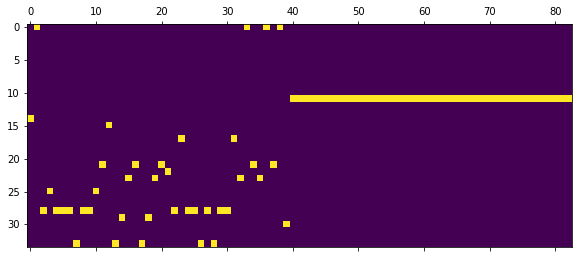

In [27]:
def vectorize(smiles):
    # mérete: (input SMILESok száma x egy reprezentáció hossza x egy karakter one-hotja)
    one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
    for i,smile in enumerate(smiles):
        #START (a 0. !)
        one_hot[i,0,char_to_int["!"]] = 1
        #karakterek kódja
        for j,c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        #END (a végéig E karakterrel lesz kitöltve)
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # X: !... Y: ...E
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
# egy smiles feldolgozás előtt
print(smiles_train.iloc[0])
# feldolgozás után: !N#...EEEEEE
plt.matshow(X_train[0].T)
# train_size x embed-1 x karakter hossz
print(X_train.shape)

# VAE MODEL

In [5]:
# 27 x 22 (27 karakter, 1 karakter 22 féle lehet)
input_shape = X_train.shape[1:]
# 22 (egy karakter)
output_dim = Y_train.shape[-1]
# látens dimenzió
latent_dim = 64
# LSTM cellák száma
lstm_dim = 64

## ENCODER: input -> h,c

In [6]:
unroll = False
encoder_inputs = Input(shape=input_shape, name='encoder_input')
encoder = LSTM(lstm_dim, return_state=True,unroll=unroll, name='LSTM1')
# 64 LSTM cella tanul rajta, a kimenet nem számít, a rejtett állapotok konkatenáltja lesz a bottleneck
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim*2, activation="relu", name='latent')
# látens reprezentáció, látens dimenzió hosszú
neck_outputs = neck(states)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# reparameterization trick
# z = mean + sqrt(var)*eps
# itt már csak eps random, a többin backpropozhatunk
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
#a bottleneckből még szórást és átlagot csinálunk
z_mean = Dense(latent_dim, name='z_mean')(neck_outputs)
z_log_var = Dense(latent_dim, name='z_log_var')(neck_outputs)
# majd ebből mintavételezünk
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [9]:
# enkóder példányosítása
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 83, 34)       0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    [(None, 64), (None,  25344       encoder_input[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           LSTM1[0][1]                      
                                                                 LSTM1[0][2]                      
__________________________________________________________________________________________________
latent (Dense)                  (None, 128)          16512       concatenate_1[0][0]              
__________

## DECODER: input+h+c -> output

In [10]:
# a látens reprezentációból visszaalakítja a h és c állapotokat
decode_h =  Dense(lstm_dim, activation="relu", name='H')
decode_c =  Dense(lstm_dim, activation="relu", name='C')
state_h_decoded =  decode_h(z)
state_c_decoded =  decode_c(z)
encoder_states = [state_h_decoded, state_c_decoded]

# loss miatt megkapja az elvárt kimenetet is
inputs = Input(shape=input_shape, name="input")

# az enkóder LST újra megkapja az inputot, a következő karaktert kell kitalálnia, az egész kimeneti karaktersorozattal tér vissza
# pl a két állapotból és a !-ből kell kitalálnia az első karaktert
# de nem a saját outputját kell tovább vinnie, hanem minden karaktert a bemenet alapján (teacher enforcing)
decoder_inputs = Input(shape=input_shape, name='decoder_input')
decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll, name='LSTM2')
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# ez becsli a karaktert minden lépés után
decoder_dense = Dense(output_dim, activation='softmax', name='output')
decoder_outputs = decoder_dense(decoder_outputs)

## VAE

In [11]:
#Inputként kétszer kapja meg a sztringeket
# enkóder része előállítja az input alapján kiszámolt állapotok tömörített vektorát
# a dekóder ezekből az állapotokból próbálja rekonstruálni az eredeti inputot
#   teacher enforcing miatt neki is megadjuk, hogy mi volt az eredeti, így a következő karaktert nem a saját előzőjéből, hanem az eredeti előzőből kell becsülnie
model = Model([encoder_inputs, decoder_inputs, inputs], decoder_outputs)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 83, 34)       0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    [(None, 64), (None,  25344       encoder_input[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           LSTM1[0][1]                      
                                                                 LSTM1[0][2]                      
__________________________________________________________________________________________________
latent (Dense)                  (None, 128)          16512       concatenate_1[0][0]              
__________

In [12]:
#csak colabon
#from keras.utils import plot_model
#plot_model(model)

## VAE PRETRAIN

In [13]:
h = History()
# akkor csökkenti a learning ratet, ha 10 epoch után se csökken a val_loss jelentősen
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

reconstruction_loss = categorical_crossentropy(K.flatten(inputs),K.flatten(decoder_outputs))
reconstruction_loss *= 1

#látens térbeli regularizálás
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
model.add_loss(vae_loss)

# 200 epochig is mehet
# bemenet: !abcEE
# ebből kell becsülnie: abcEEE
opt=Adam(lr=0.005)
model.compile(optimizer=opt)

C:\Conda\envs\Tensorflow-GPU\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [14]:
if (load):
    model.load_weights('vae_SMILES.h5')
else:
    model.fit([X_train,X_train, Y_train],None,
              epochs=50,
              batch_size=256,
              shuffle=True,
              callbacks=[h, rlr],
              validation_data=[[X_test,X_test, Y_test],None])
    model.save_weights('vae_SMILES.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 75000 samples, validate on 25000 samples
Epoch 1/50
75000/75000 [==============================] - 121s 2ms/step - loss: 228263.8249 - val_loss: 220857.5146
Epoch 2/50
75000/75000 [==============================] - 131s 2ms/step - loss: 220376.1658 - val_loss: 219118.5931
Epoch 3/50
75000/75000 [==============================] - 134s 2ms/step - loss: 219367.8223 - val_loss: 218552.3811
Epoch 4/50
75000/75000 [==============================] - 130s 2ms/step - loss: 218887.6641 - val_loss: 218265.6429
Epoch 5/50
75000/75000 [==============================] - 132s 2ms/step - loss: 218571.0481 - val_loss: 217786.6271
Epoch 6/50
75000/75000 [==============================] - 127s 2ms/step - loss: 218192.2488 - val_loss: 217473.2596
Epoch 7/50
75000/75000 [==============================] - 131s 2ms/step - loss: 217945.4622 - val_loss: 217324.6976
Epoch 8/50
7

KeyboardInterrupt: 

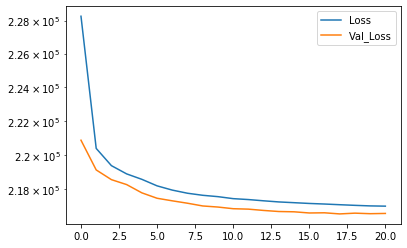

In [15]:
if (not load):
    # loss és val loss logaritmikus skálán
    plt.plot(h.history["loss"], label="Loss")
    plt.plot(h.history["val_loss"], label="Val_Loss")
    plt.yscale("log")
    plt.legend()

# SAMPLING MODEL

## SMILES -> latent

In [16]:
# !abcEE -> dense([h,c])
smiles_to_latent_model = Model(encoder_inputs, z)
if (load):
    smiles_to_latent_model.load_weights("smi2lat.h5")

## latent -> states

In [17]:
latent_input = Input(shape=(latent_dim,))
#a már betanult konvertálókat használja
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
# dense([h,c]) -> [h', c']
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
if (load):
    latent_to_states_model.load_weights("lat2state.h5")

## state -> SMILES

In [18]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
#batchek között átadódik az utolsó state
inf_decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll, stateful=True)
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
# [h,c] -> karakter 
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

# súlyok öröklése az előző modell dekóderjéből, most csak így lehet, mert új LSTM réteget kellett hozádni ami már stateful
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+9].get_weights())

if (load):
    sample_model.load_weights("samplemodel.h5")
    
sample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 1, 34)                0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 1, 64)                25344     
_________________________________________________________________
dense_1 (Dense)              (1, 1, 34)                2210      
Total params: 27,554
Trainable params: 27,554
Non-trainable params: 0
_________________________________________________________________


# LATENT SPACE

In [35]:
# tesztadatok leképezése látens térbe
x_latent = smiles_to_latent_model.predict(X_test)

In [20]:
# adott sorszámú molekula leképezése
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
# 10 a látens térben legközelebb elhelyezkedő molekula
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))

print("Original: ", smiles_test.iloc[molno])
print("Similar:")
print(smiles_test.iloc[sorti[1:10]])


Original:  C[C@H]1CN(C[C@@H](O1)C)S(=O)(=O)c2ccc(cc2)Oc3ccccc3
Similar:
1570      c1ccc2c(c1)nc(s2)NC(=O)[C@@H]3C[C@H]4CC[C@@H]3C4
1162           CCN(CC)C(=O)[C@@]1(C[C@@H]1C[NH3+])c2ccccc2
52053      c1ccc(cc1)[C@@H]2[C@@H](C(=O)c3ccccc3O2)NC(=O)N
63536    c1cc(ccc1CC(=O)[O-])NC(=O)[C@@H]2CC=CC[C@H]2C(...
87256              C[C@H]1CC(O[C@@H](O1)C[NH+]2CCCCC2)(C)C
28322     Cc1nccn1CCCN2C(=O)O[C@@]([C@@]2(C)O)(C)CCC=C(C)C
34606    CC1(CC(CC([NH2+]1)(C)C)N2C(=O)OC([C@]2(C)O)(C)C)C
88140    c1ccc2c(c1)c3ccc(cc3o2)NC(=O)[C@@H]4CC=CC[C@H]...
10081    c1ccc(cc1)NC(=O)[C@@H]2C[C@@H](CN2C(=O)Oc3cccc...
Name: smiles, dtype: object


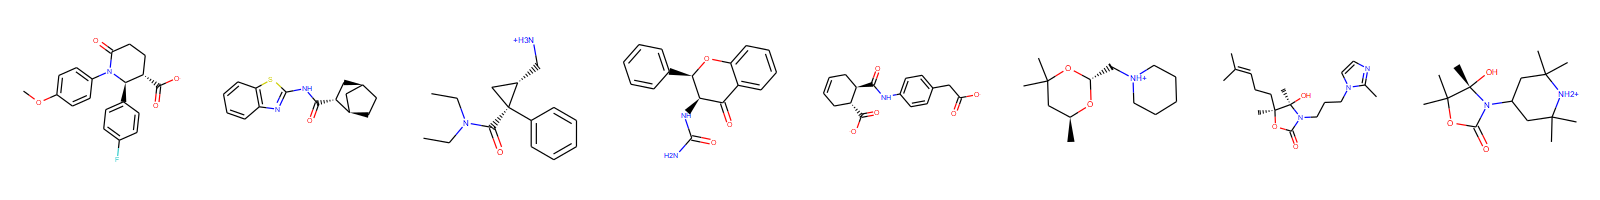

In [21]:
# 8 leghasonlóbb molekula kirajzolása
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

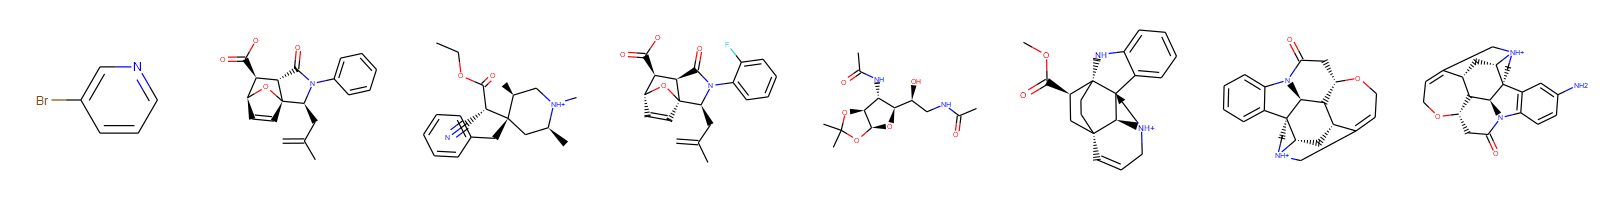

In [22]:
# 8 legeltérőbb
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

In [28]:
# logp és molwt tujaldonságok leképzése látens térben
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)

plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcCrippenDescriptors(NoneType)
did not match C++ signature:
    CalcCrippenDescriptors(class RDKit::ROMol mol, bool includeHs=True, bool force=False)

In [31]:
#szekvenciális modell a látens térbeli reprezentációból képes megtanulni a logP tulajdonságot
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)
from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")

rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=200, callbacks = [rlr])

In [ ]:
# egyes logP értékekre miket predikált
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.legend()

In [ ]:
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()

# GENERATE

In [39]:
# látens -> smiles
def latent_to_smiles(latent):
    #látens tér -> állapotok -> LSTM állapotainak visszaállítása
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #első karakter a !
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,output_dim))
    samplevec[0,0,startidx] = 1
    smiles = ""

    for i in range(28):
        # mintavételezett karakter az előző alapján
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        # ha nincs vége, következő karakter előkészítése, kimenet hozzáfűzése
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,output_dim))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [40]:
# pl adott smiles reprezentációjából képes visszaállítani ugyanazt a smilest
smiles = latent_to_smiles(x_latent[0:1])
print(smiles)
print(smiles_test.iloc[0])

c1ccc(cc1)C(=O)Nc2ccc(cc2)Cl
Cc1ccnc(c1)NC(=O)c2ccccc2I


In [41]:
# letesztelni, hogy hány százaléka a generáltnak nincs jó smiles formátumban
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print(smiles)
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))

CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC1(C[C@@H]([C@@H](O1)C)C(=O
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(=O)Nc1ccc(cc1)C(=O)N2CCC(
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
c1ccc(cc1)C(=O)Nc2ccc(cc2)C(
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)[NH2+]C[C@@H]1c2cccc
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC1(C[C@@H]([C@@H](O1)C)C(=O
CC(=O)Nc1ccc(cc1)C(=O)N2CCC(
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC1(C[C@@H]([C

CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(C)(C)c1ccc(cc1)C(=O)N2CCC
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(C)(C)OC(=O)N1CCC(CC1)C(=O
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC1(C[C@@H]([C@@H]([C@@H](O1
CC(=O)Nc1ccc(cc1)C(=O)N2CC[N
CC(C)(C)c1ccc(cc1)C(=O)Nc2cc
CC(C)(C)OC(=O)N1CCC[C@H]1C(=
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(=O)Nc1ccc(cc1)C(=O)Nc2ccc
CC(=O)Nc1ccc(c

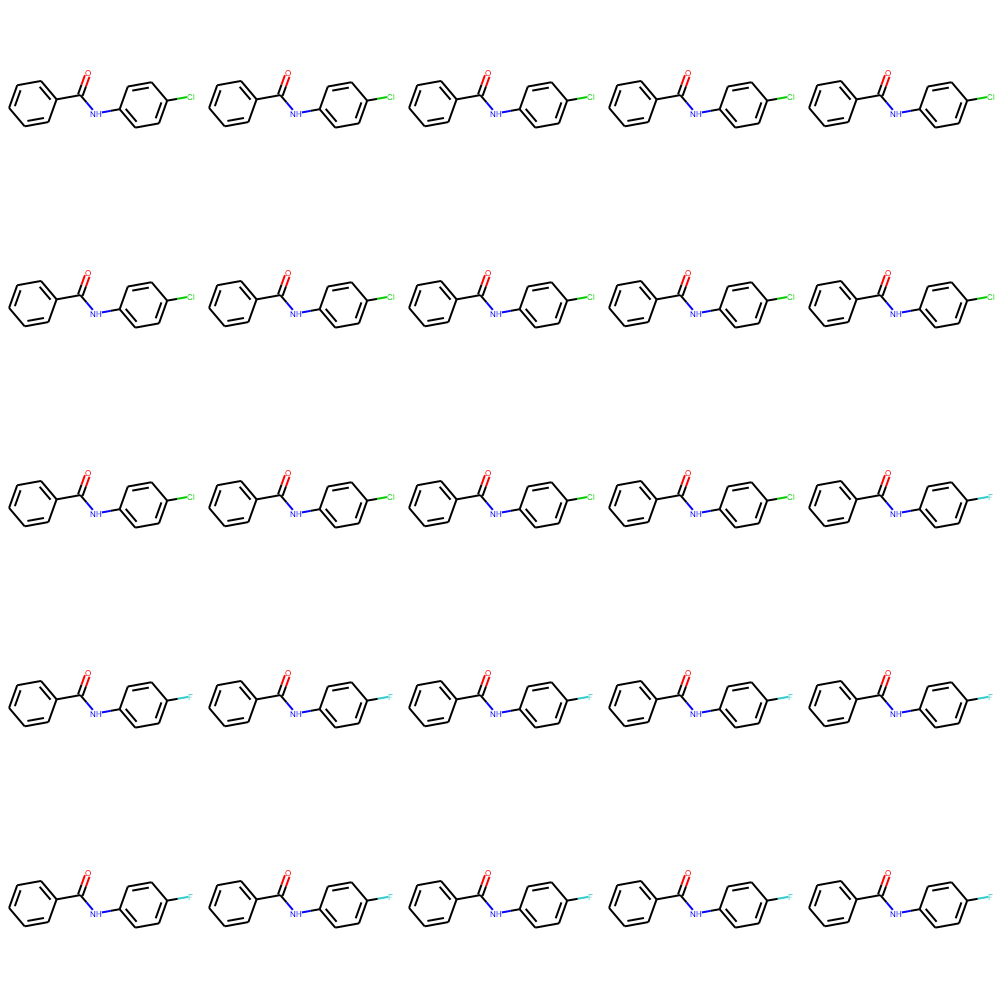

In [42]:
#Látens térbeli interpoláció tesztelése
# ha lehet akkor kirajzolja, ha nem akkor csak kiírja a sztringet
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)

c1ccc(cc1)C(=O)Nc2ccc(cc2)C(
c1ccc(cc1)c2ccc(cc2)C(=O)[O-
c1ccc(cc1)C(=O)Nc2ccc(cc2)C(


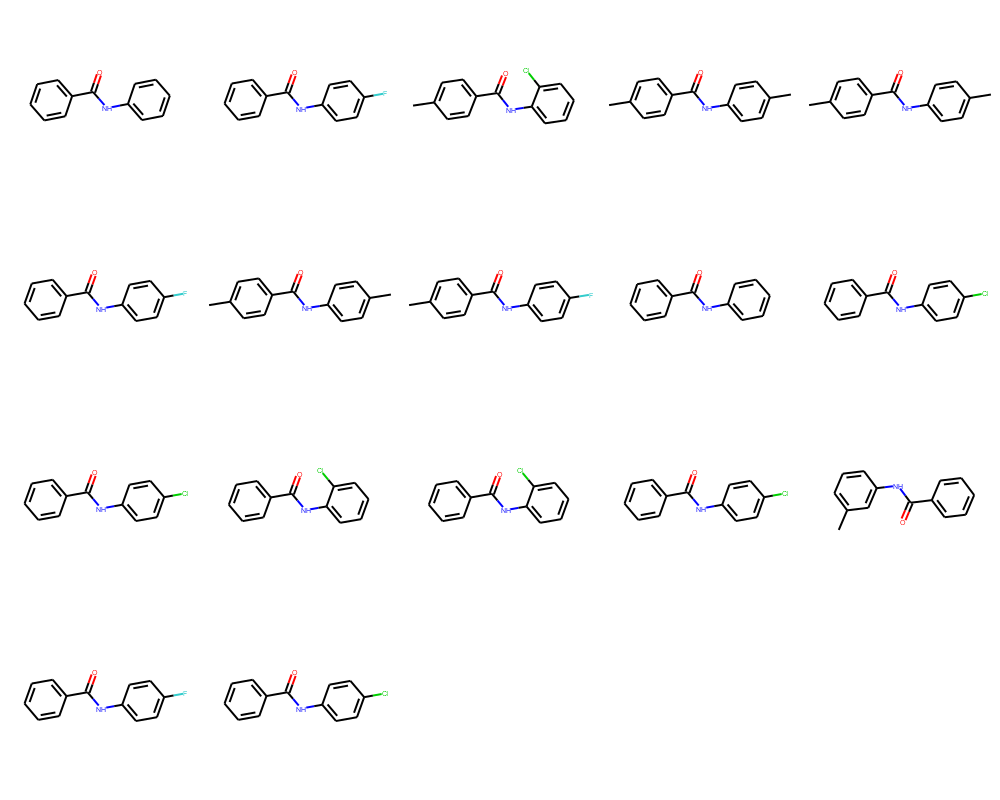

In [43]:
#egy adott látens vektor körül mintavételezünk, megnézzük, hogy valid-e, és mennyire tér el
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)

C:\Conda\envs\Tensorflow-GPU\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


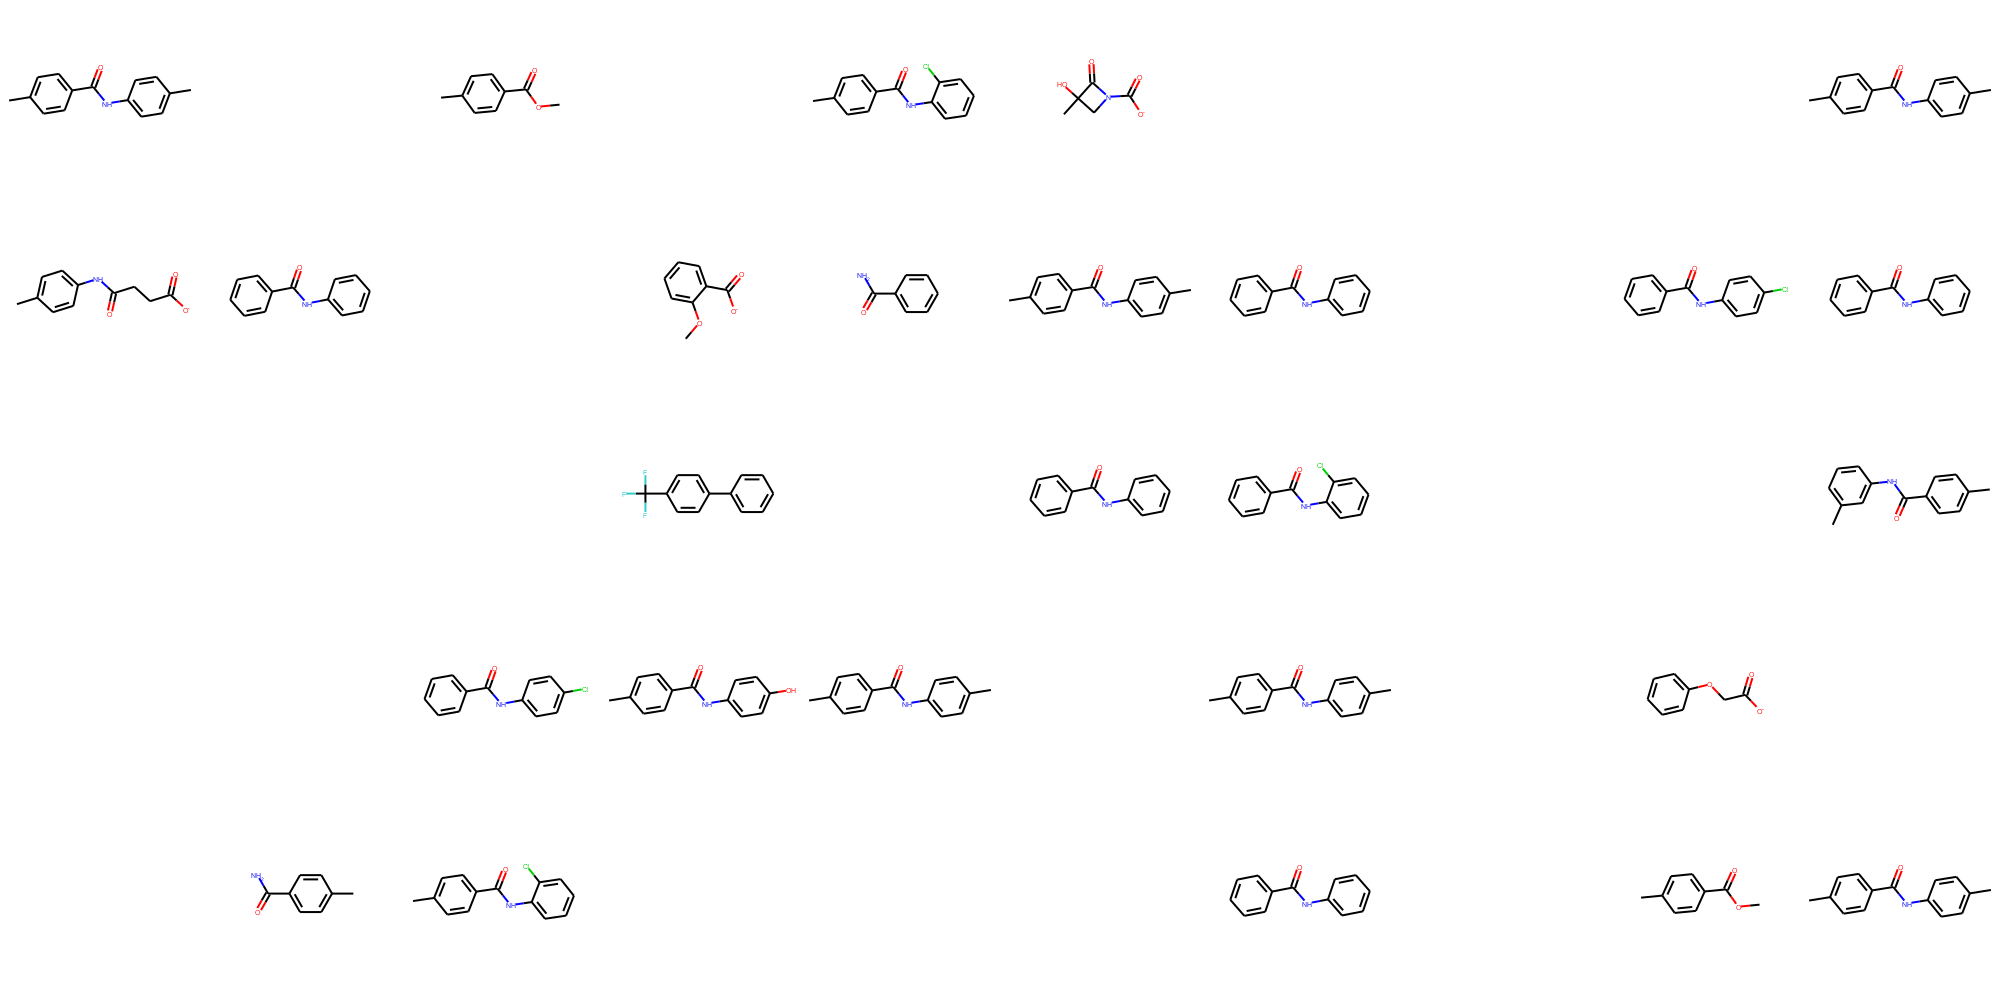

In [44]:
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]
#látens térből generálás
mols1 = []
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        latent = np.random.normal(0.0, 1, (1,latent_dim))
        latent[0,0]=xi
        latent[0,1]=yi
        smiles  = latent_to_smiles(latent)
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mols1.append(mol)
        else:
            mols1.append(Chem.MolFromSmiles(""))
Draw.MolsToGridImage(mols1, molsPerRow=10)